In [ ]:
%%capture
!pip install statsforecast

In [ ]:
##########
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import norm
from statsforecast import StatsForecast
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA
)
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

# Set environment variable
os.environ['NIXTLA_ID_AS_COL'] = '1'

##########
# Read the data
df = pd.read_csv("https://raw.githubusercontent.com/Wanling-Rebecca/Machine-Learning/main/PRSA_Data_Changping_20130301-20170228.csv", delimiter=",")

df_nixtla = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')

In [ ]:
df_nixtla.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


In [ ]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,Changping
1,2,2013,3,1,1,3.0,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Changping
2,3,2013,3,1,2,3.0,3.0,22.0,13.0,400.0,74.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Changping
3,4,2013,3,1,3,3.0,6.0,12.0,8.0,300.0,81.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Changping
4,5,2013,3,1,4,3.0,3.0,14.0,8.0,300.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Changping


In [ ]:
df.dtypes

,0
No,int64
year,int64
month,int64
day,int64
hour,int64
PM2.5,float64
PM10,float64
SO2,float64
NO2,float64
CO,float64


In [ ]:
df = df.drop(columns=["station","wd","No"]).dropna()

In [ ]:
df_nixtla.dtypes

,0
unique_id,object
ds,int64
y,float64


In [ ]:
df.dtypes

,0
year,int64
month,int64
day,int64
hour,int64
PM2.5,float64
PM10,float64
SO2,float64
NO2,float64
CO,float64
O3,float64


In [ ]:
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,2013,3,1,0,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,0.5
1,2013,3,1,1,3.0,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,0.7
2,2013,3,1,2,3.0,3.0,22.0,13.0,400.0,74.0,-3.0,1021.3,-19.9,0.0,0.2
3,2013,3,1,3,3.0,6.0,12.0,8.0,300.0,81.0,-3.6,1021.8,-19.1,0.0,1.0
4,2013,3,1,4,3.0,3.0,14.0,8.0,300.0,81.0,-3.5,1022.3,-19.4,0.0,2.1


In [ ]:
import pandas as pd

# Convert the combined string to datetime
df['ds'] = pd.to_datetime(df[['year','month','day','hour']], format='%d/%m/%Y %H.%M.%S')

In [ ]:
df = df.drop(columns=['year','month','day','hour'])

In [ ]:
df.set_index("ds", inplace=True)

In [ ]:
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
ds,,,,,,,,,,,
2013-03-01 00:00:00,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,0.5
2013-03-01 01:00:00,3.0,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,0.7
2013-03-01 02:00:00,3.0,3.0,22.0,13.0,400.0,74.0,-3.0,1021.3,-19.9,0.0,0.2
2013-03-01 03:00:00,3.0,6.0,12.0,8.0,300.0,81.0,-3.6,1021.8,-19.1,0.0,1.0
2013-03-01 04:00:00,3.0,3.0,14.0,8.0,300.0,81.0,-3.5,1022.3,-19.4,0.0,2.1


In [ ]:
df = df.stack()
df.head()

ds               
2013-03-01  PM2.5      3.0
            PM10       6.0
            SO2       13.0
            NO2        7.0
            CO       300.0
dtype: float64

In [ ]:
df = df.reset_index()

In [ ]:
df.head()

,ds,level_1,0
0,2013-03-01,PM2.5,3.0
1,2013-03-01,PM10,6.0
2,2013-03-01,SO2,13.0
3,2013-03-01,NO2,7.0
4,2013-03-01,CO,300.0


In [ ]:
df_nixtla.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


In [ ]:
df.columns = ["ds", "unique_id", "y"]
df = df[["unique_id", "ds", "y"]]

In [ ]:
df.sort_values(["unique_id","ds"])

,unique_id,ds,y
4,CO,2013-03-01 00:00:00,300.0
15,CO,2013-03-01 01:00:00,300.0
26,CO,2013-03-01 02:00:00,400.0
37,CO,2013-03-01 03:00:00,300.0
48,CO,2013-03-01 04:00:00,300.0
...,...,...,...
360469,WSPM,2017-02-28 17:00:00,4.2
360480,WSPM,2017-02-28 20:00:00,2.1
360491,WSPM,2017-02-28 21:00:00,1.5
360502,WSPM,2017-02-28 22:00:00,1.4


In [ ]:
df = df.groupby('unique_id').apply(lambda x: x.resample('H', on='ds').last())

In [ ]:
df = df.drop(columns='unique_id').reset_index()

In [ ]:
Y_df = df.copy()

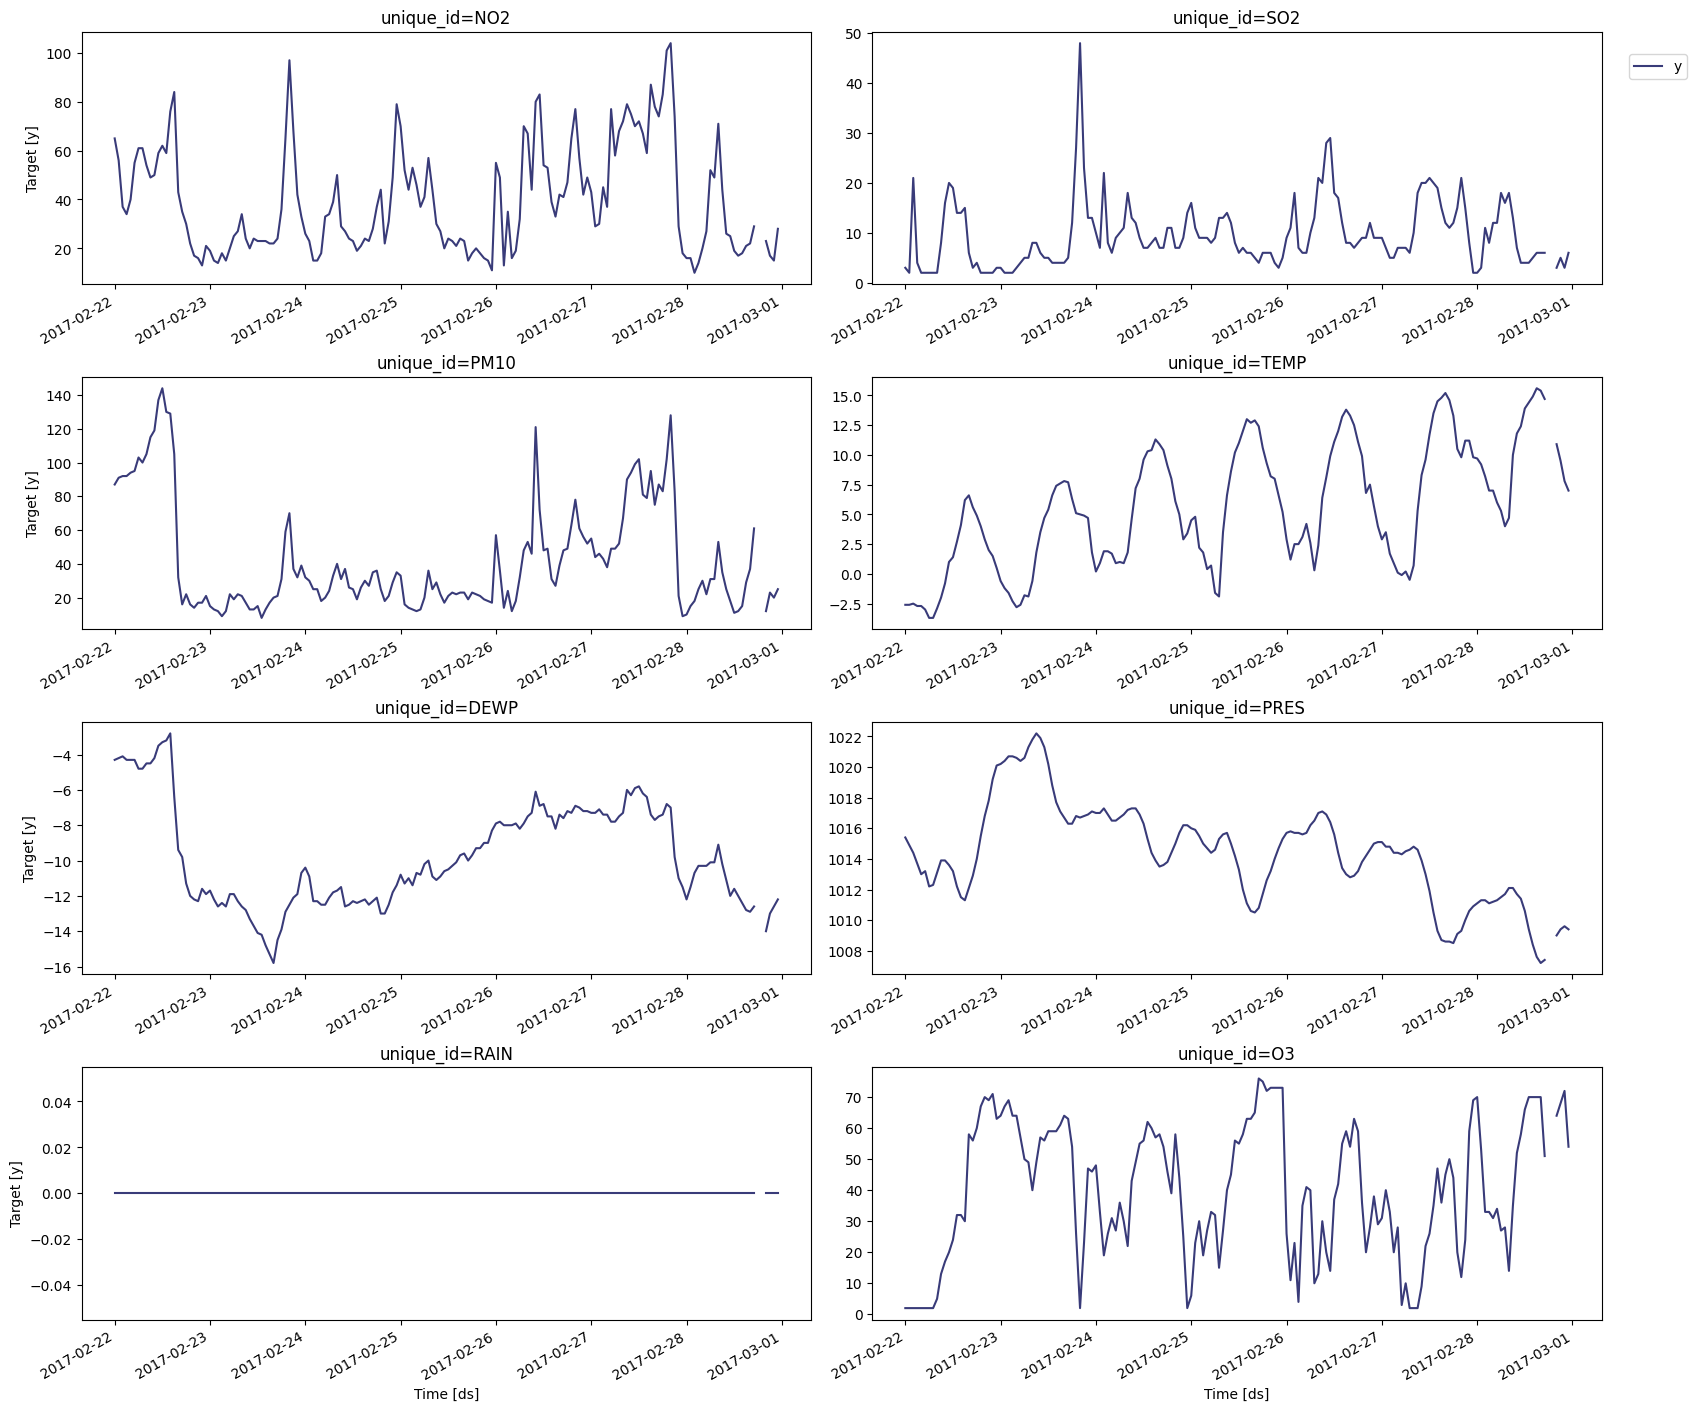

In [ ]:
# Select subset of data
uids = Y_df['unique_id'].unique()[:10]
Y_df = Y_df.query('unique_id in @uids')
Y_df = Y_df.groupby('unique_id').tail(7 * 24)

##########
# Explore data
StatsForecast.plot(Y_df)



1. HoltWinters: Triple exponential smoothing, good for data with both trend and seasonality.
1. Croston: Designed for intermittent demand forecasting.
1. SeasonalNaive(season_length=24): Uses the value from the same time in the previous season. The season_length=24 suggests hourly data with daily seasonality.
1. HistoricAverage: Uses the mean of all historical data points.
1. DOT (Dynamic Optimized Theta): A variant of the Theta method, good for data with seasonality.

In [ ]:
##########
# Define models
models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24),
    # AutoARIMA(season_length=24) ## slightly slow ignoring for now
]

#The season_length=24 refers to hourly data with daily seasonality.

# Instantiate StatsForecast
sf = StatsForecast(
    models=models,
    # freq=1,
    freq='H', # have to add ## freq='D', because dealing with real dates
    fallback_model = SeasonalNaive(season_length=3), ## if other models fail
    n_jobs=-1,
)



* df=Y_df: The input data frame.
* h=48: Forecast horizon of 48 time units (likely 48 hours).
* level=[90]: Generates 90% prediction intervals.

In [ ]:
# Generate forecasts
forecasts_df = sf.forecast(df=Y_df, h=48, level=[90])

Up to here is good, you can finish here

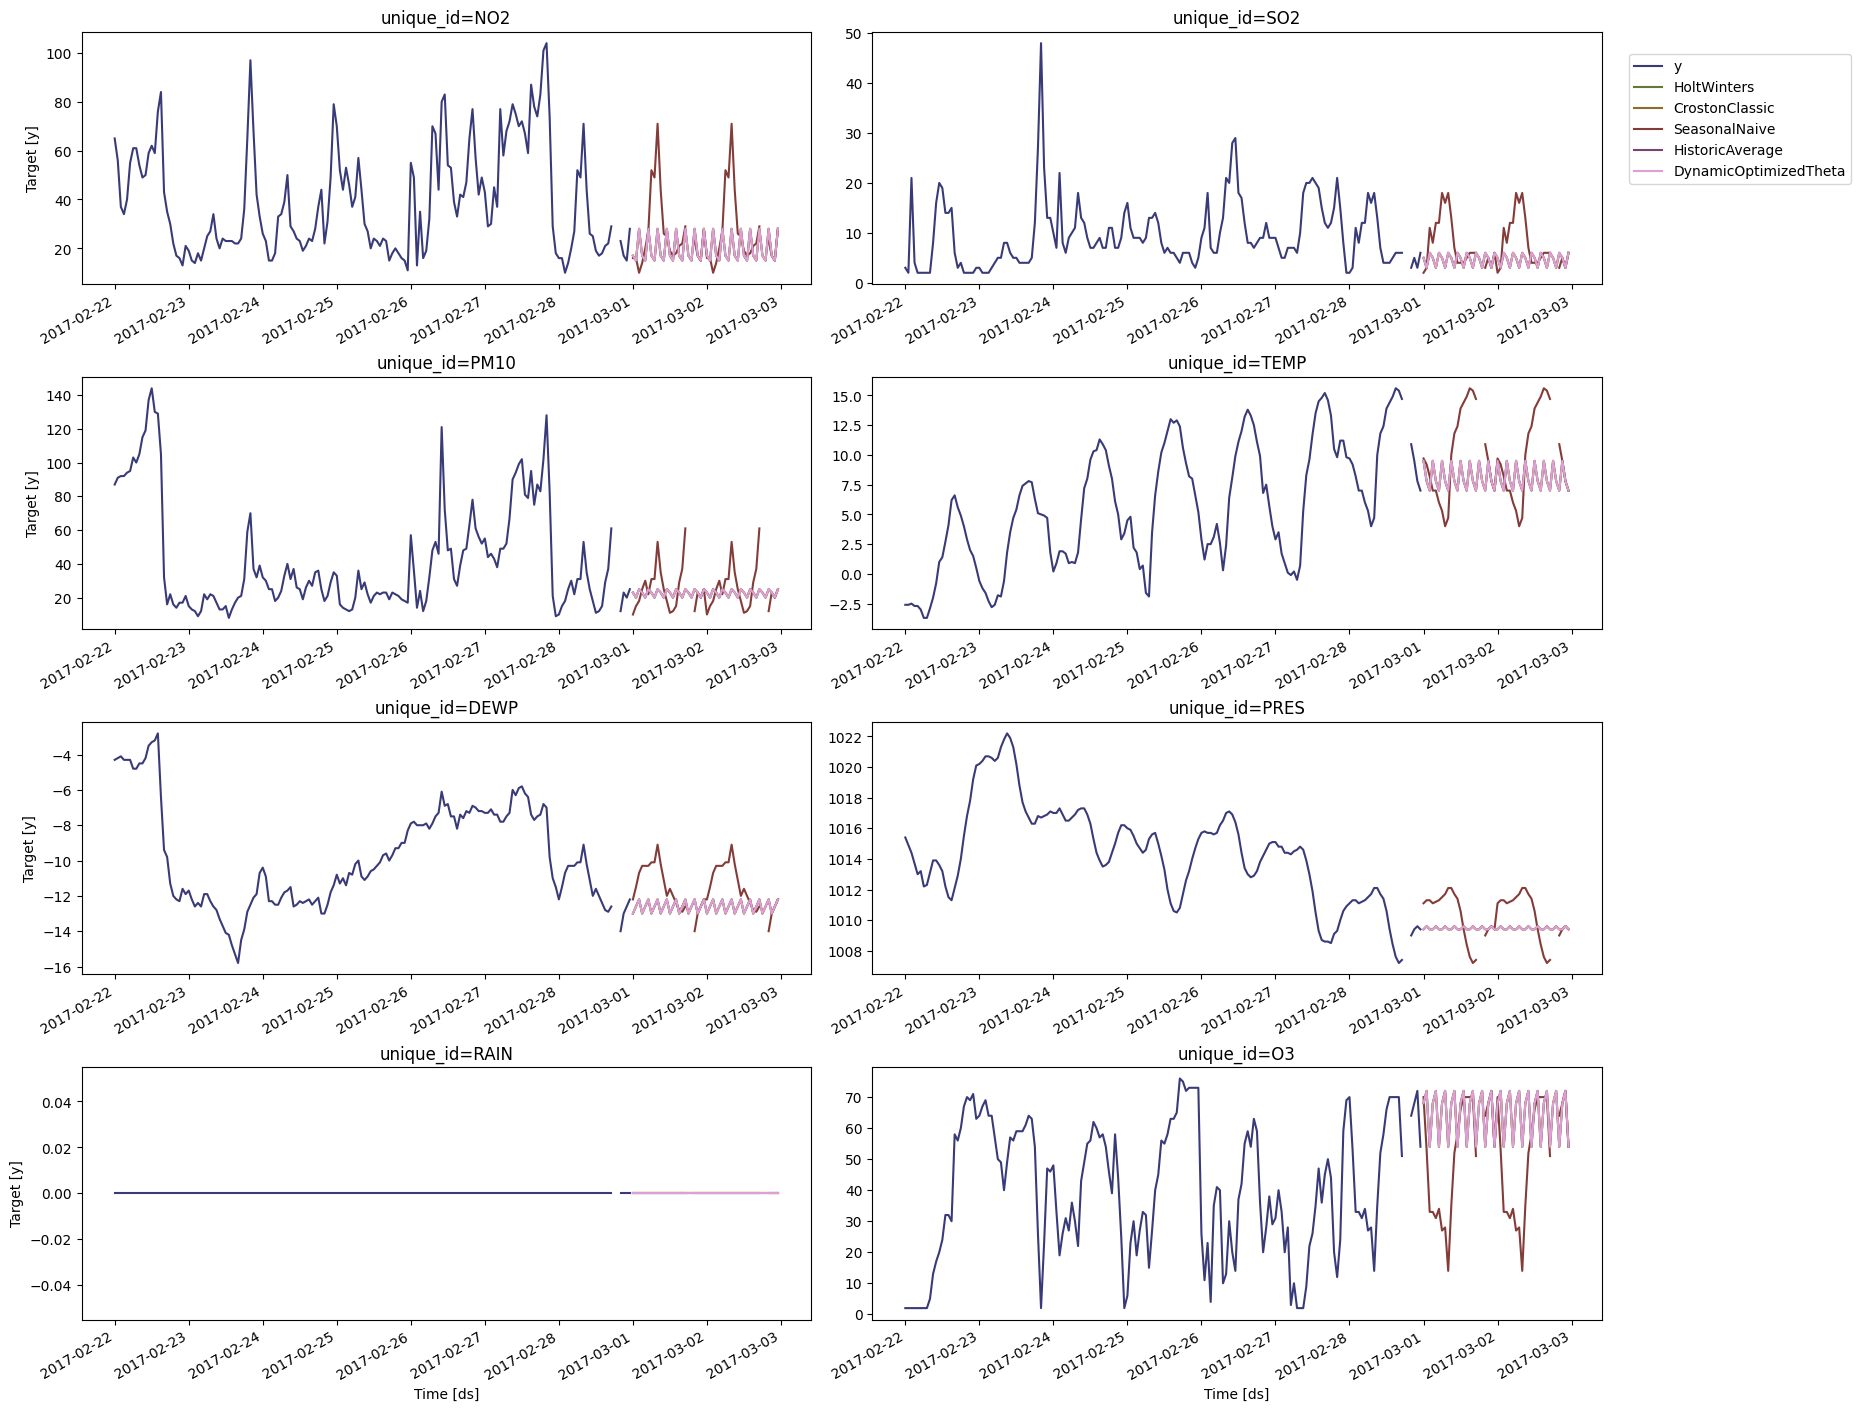

In [ ]:
##########
# Plot forecasts
sf.plot(Y_df, forecasts_df)

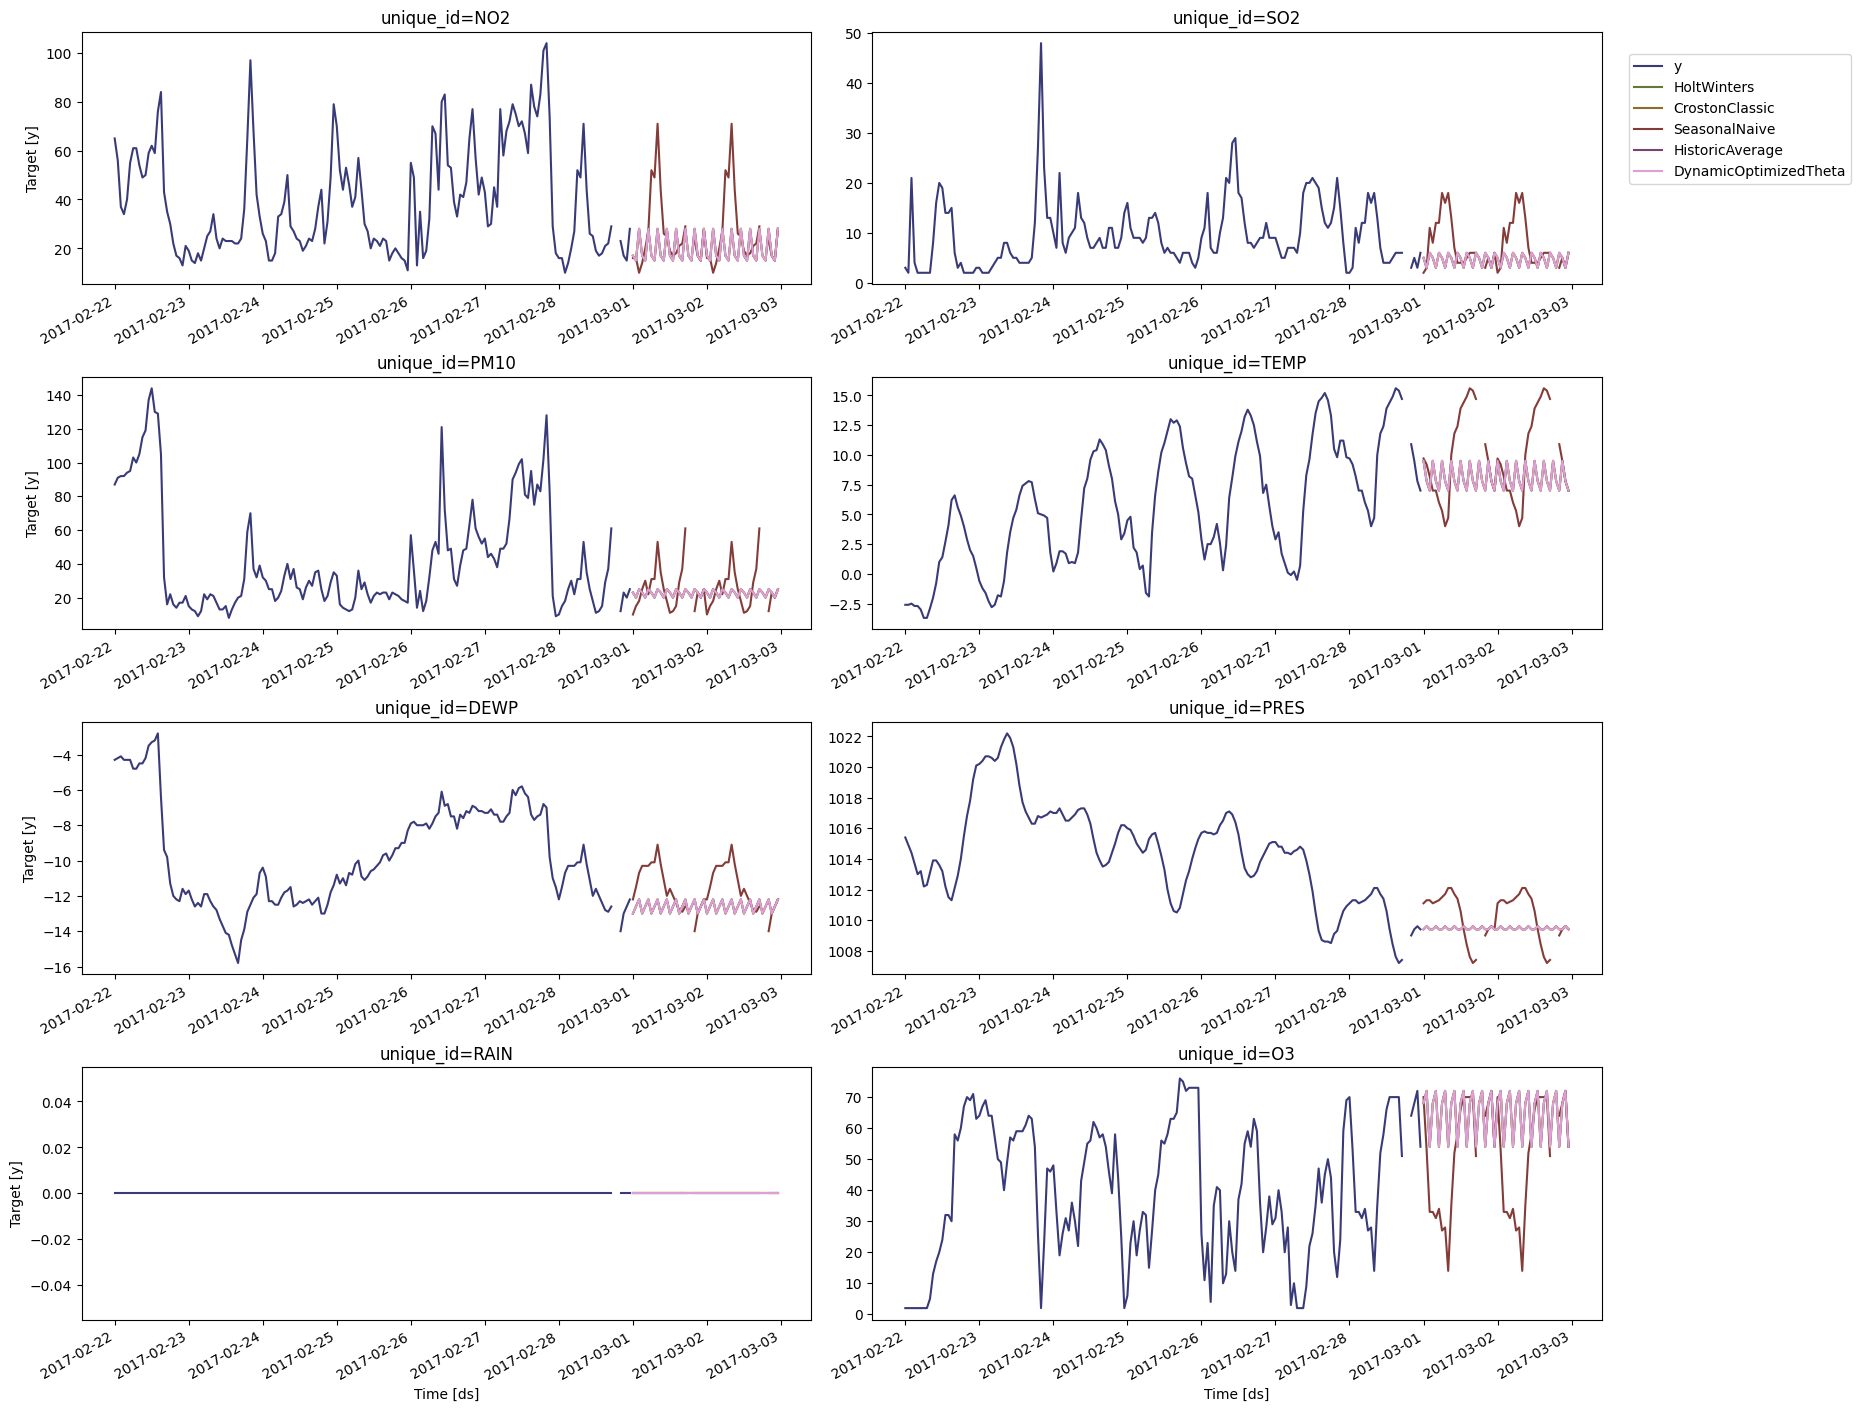

In [ ]:
##########
# Plot forecasts
sf.plot(Y_df, forecasts_df)

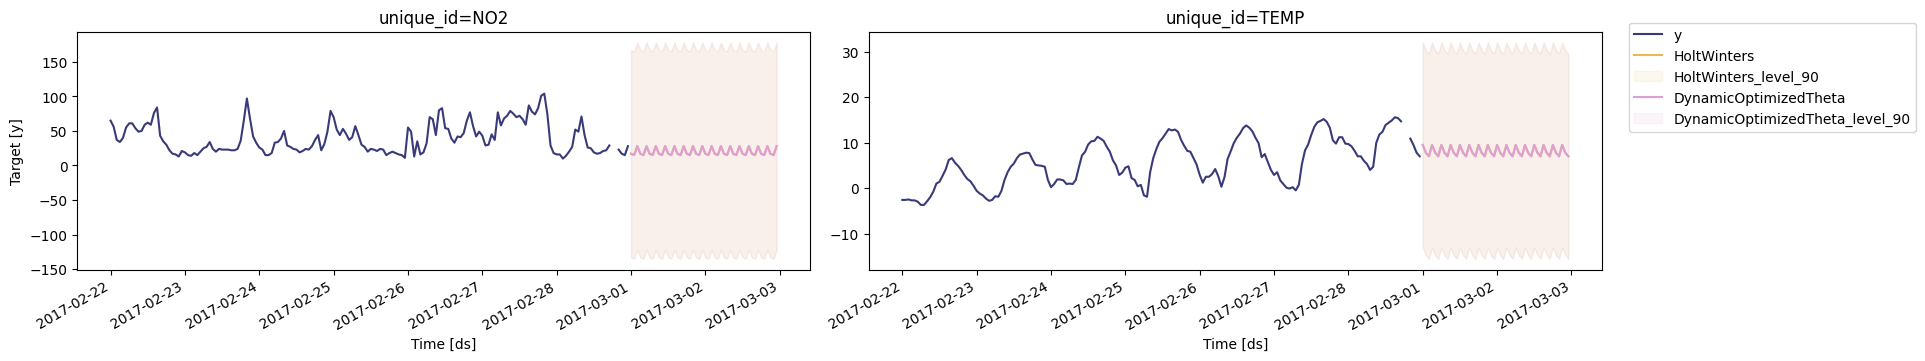

In [ ]:
sf.plot(Y_df, forecasts_df, models=["HoltWinters","DynamicOptimizedTheta"], unique_ids=["NO2", "TEMP"], level=[90])


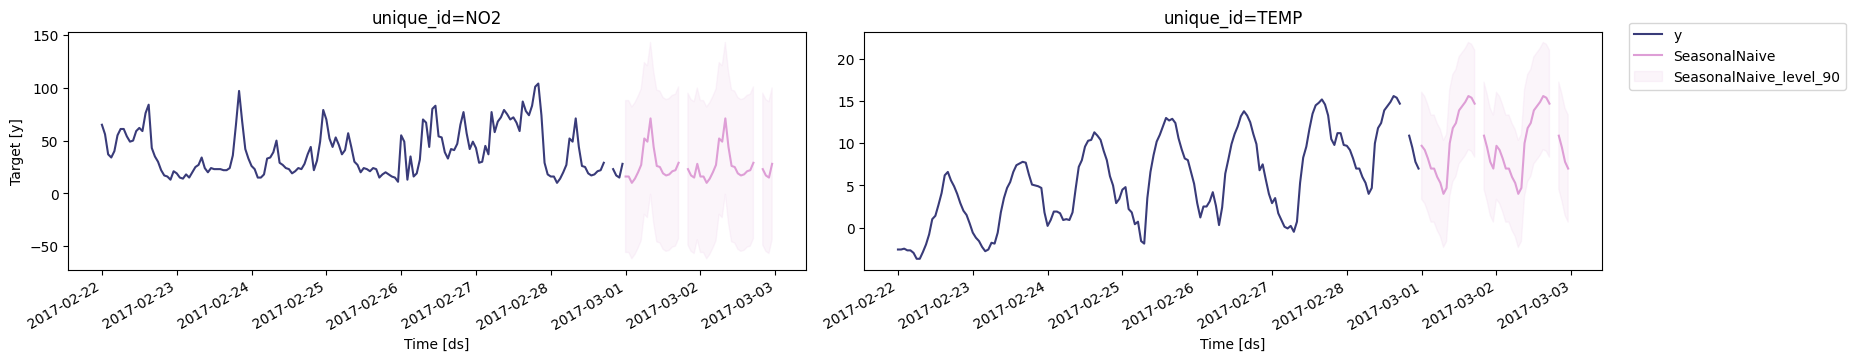

In [ ]:
sf.plot(Y_df, forecasts_df, models=["SeasonalNaive"], unique_ids=["NO2", "TEMP"], level=[90])

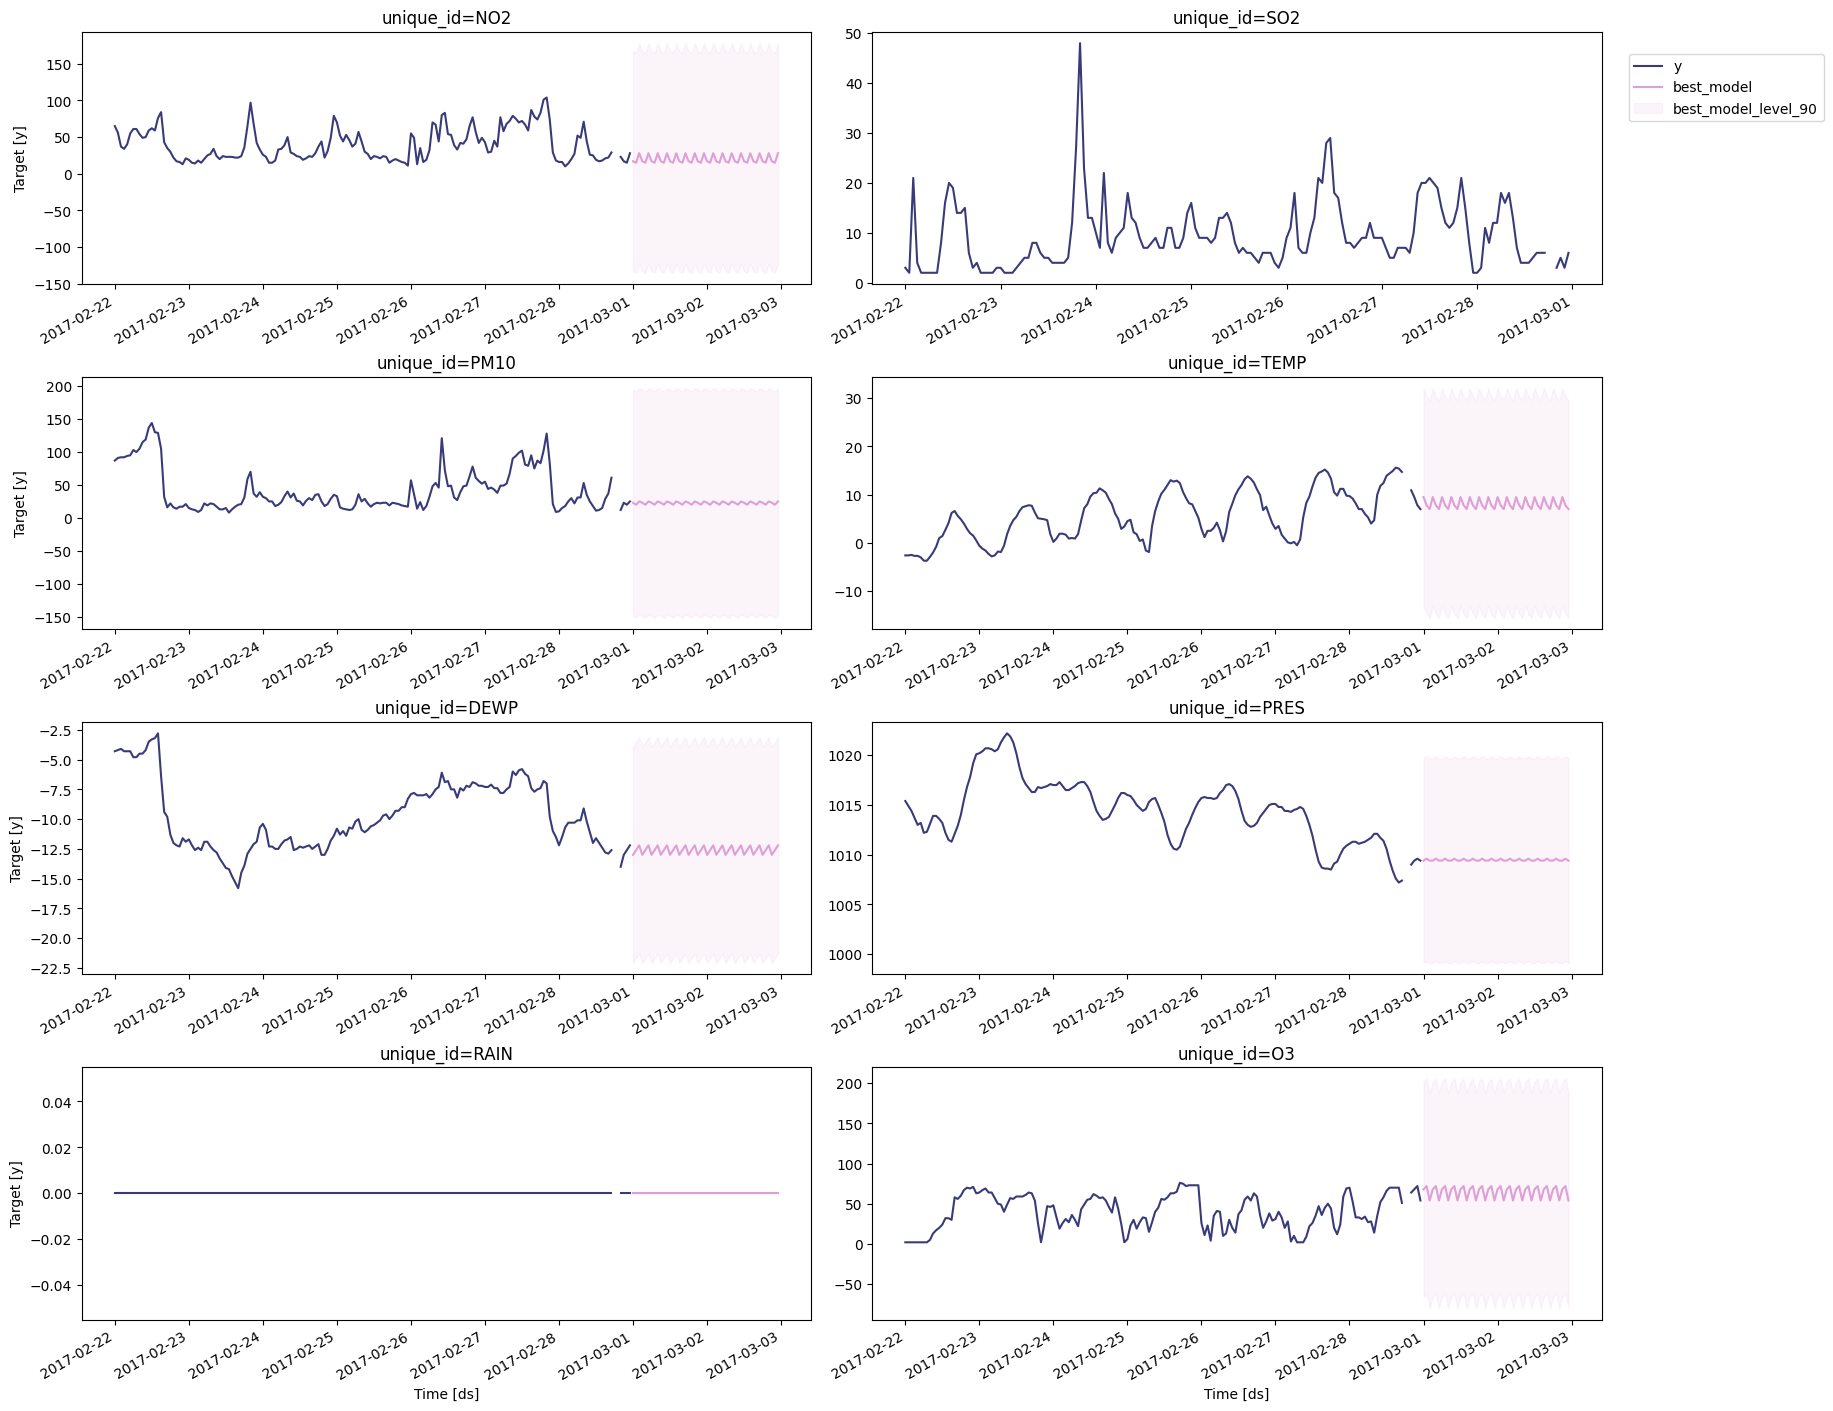

In [ ]:
##########
# Select best model for each series
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index(['unique_id', 'ds']).stack().to_frame().reset_index(level=2)
    df.columns = ['model', 'best_model_forecast']
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df.columns.name = None
    df = df.reset_index()
    return df

# Get best model forecasts
prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)

# Plot final results
sf.plot(Y_df, prod_forecasts_df, level=[90])

##########